# Optimal control transport of trapped ions 
Transport of trapped ions is a key tool in trapped ion experiments. The task of moving one ion from A to B in the trap can be split into a series of interconnected optimization problems.

Reference: Optimal control transport of neutral atoms in optical tweezers at finite temperature, 
https://doi.org/10.1103/PhysRevResearch.6.033282

1. Reproduce the optimal control transport task discussed in the paper for the case of trapped ions. Formulate the problem as the 1D transport of one particle in a harmonic potential (rather than gaussian) and find a trajectory with minimal excitation using realistic trap parameters. You can use the python package referenced in the paper https://pypi.org/project/quocs-lib/ <br>
Bonus: transport two ions, use two control parameters (position and trap frequency), and minimize the excitation of both the COM and STR mode. 
2. Implement the transport in a realistic ion trap. Build an electrostatic model for a surface electrode trap, and find the voltage waveforms that reproduce the optimal control trajectory. I suggest using the python package pytrans https://pypi.org/project/pytrans/ (and related 
examples) 

By the due date please submit the presentation and the code. The final presentation will be 20 minutes long and you have to present the problem, methods and results. A final question on the program of the Quantum Information and Computing course will conclude the exam.

**Import zone**

In [43]:
import numpy as np
import debugger as db
import auxiliary_functions as aux
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm

In [56]:
# ===========================================================================================================
# PARAM CLASS
# ===========================================================================================================

class Param:
  """
  Param: 
    Container for holding all simulation parameters.
  """
  def __init__(self,
               x_min: float,
               x_max: float,
               num_x: int,
               tsim: float,
               num_t: int,
               im_time: bool = False) -> None:
    """
    __init__ : 
      Initialize simulation parameters.

    Parameters
    ----------
    x_min : float
      Minimum spatial value.
    x_max : float
      Maximum spatial value.
    num_x : int
      Number of spatial grid points.
    tsim : float
      Total simulation time.
    num_t : int
      Number of time steps.
    im_time : bool, optional
      Whether to use imaginary time evolution. Default is False.
    """
    # Initialization
    self.x_min = x_min
    self.x_max = x_max
    self.num_x = num_x
    self.tsim = tsim
    self.num_t = num_t
    self.im_time = im_time

    # Infinitesimal quantities (space, time, momentum)
    self.dx = (x_max - x_min) / num_x
    self.dt = tsim / num_t
    self.dk = 2 * np.pi / (x_max - x_min)

    # Spatial grid
    self.x = np.linspace(x_min + 0.5 * self.dx, x_max - 0.5 * self.dx, num_x)

    # Momentum grid -> For FFT, frequencies are in this order
    self.k = np.fft.fftfreq(num_x, d=self.dx) * 2 * np.pi

    # validation check
    self._validate()

  def _validate(self) -> None:
    """
    _validate :
      Check for common errors in parameter initialization.
    """
    if self.num_x <= 0 or self.num_t <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: num_x and num_t must be positive integers.", stop=True)
    if self.x_max <= 0 or self.tsim <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: xmax and tsim must be positive values.", stop=True)
      
      
# ===========================================================================================================
# OPERATORS CLASS
# ===========================================================================================================

class Operators:
  """
  Container for holding operators and wavefunction coefficients.
  """
  def __init__(self, 
               res: int, 
               voffset: float = 0,
               wfcoffset: float = 0,
               omega: float = 1.0,
               order: int = 2,
               n_max: int = 1,
               r_t=None, 
               par: Param = None,
               T = 10e-6) -> None:
    """
    __init__: 
      Initialize operator arrays and configure time-dependent potential 
      and wavefunction.

    Parameters
    ----------
    res : int
      Resolution of the spatial domain (number of grid point).
    voffset : float, optional
      Offset of the quadratic potential in real space. Default is 0.
    wfcoffset : float, optional
      Offset of the wavefunction in real space. Default is 0.
    omega : float
      Angular frequency of the harmonic oscillator. Default is 1.0.
    order : int
      Order of the finite difference approximation. Default is 2.
    n_max : int, optional
      Maximum order of the Hermite polynomial. Default is 0.
    r_func : callable, optional
      A function r_func(t) defining the time-dependent offset r(t). 
      Default is None.
    par : Param, optional
      Instance of the Param class containing simulation parameters, 
      used to initialize grid-related quantities. Default is None.
    """
    # Initialize empty complex arrays for potential, propagators, and wavefunction
    self.V = np.empty(res, dtype=complex)  # Potential operator
    self.R = np.empty(res, dtype=complex)  # Real-space propagator
    self.K = np.empty(res, dtype=complex)  # Momentum-space propagator
    self.wfcs = np.empty((n_max+1, res), dtype=complex)  # Wavefunction coefficients
    self.shifted_wfcs = np.empty((n_max+1, res), dtype=complex)  # Shifted wavefunction coefficients
    
    # Store finite temperature
    self.T = T

    # Store approximation order
    self.order = order
    
    # Energy list (finite temperature case)
    self.energies = []
    self.rho = []
    self.shifted_rho = []
    
    # Store time-dependent offset function (default to no potential if None)
    self.r_t = r_t if r_t is not None else np.zeros(par.num_t)
    
    # Store angular frequency
    self.omega = omega
    
    # Store maximum order of the Hermite polynomial
    self.n_max = n_max

    # Initialize potential and wavefunction if a Param instance is provided
    if par is not None:
      self._initialize_operators(par, voffset, wfcoffset)
      self.calculate_energy(par)
      self.density_matrix()
      self.shifted_density_matrix()

  def _initialize_operators(self, par: Param, voffset: float, wfcoffset: float) -> None:
    """
    _initialize_operators: 
      Initialize operators and wavefunction based on the provided parameters.

    Parameters
    ----------
    par : Param
      Simulation parameter instance containing grid and time information.
    voffset : float
      Offset of the quadratic potential in real space.
    wfcoffset : float
      Offset of the wavefunction in real space.
    order: int
      Order of the finite difference approximation
    n_max : int
      Maximum order of the Hermite polynomial.
      
    Returns
    -----------
    None (acts in place).
    """    
    # Initial time-dependent offset (at t=0)
    r0 = self.r_t[0]

    # Quadratic potential with offset
    self.V = 0.5 * (par.x - voffset - r0) ** 2 * self.omega **2

    # Wavefunction based on a harmonic oscillator eigenstate
    self.wfcs = aux.harmonic_oscillator_spectrum(par.x - wfcoffset, self.omega, self.order, self.n_max)
    self.shifted_wfcs = self.wfcs
    
    # Coefficient for imaginary or real time evolution
    coeff = 1 if par.im_time else 1j

    # Momentum and real-space propagators
    self.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    self.R = np.exp(-0.5 * self.V * par.dt * coeff)


  def get_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n > self.n_max:
      raise ValueError(f"Requested wavefunction n={n} exceeds n_max={self.n_max}")
    return self.wfcs[:, n]


  def calculate_energy(self, par: Param) -> float:
    """
    calculate_energy:
      Calculate the energy <Psi|H|Psi>.

    Parameters
    ----------
    par : Param
      Parameters of the simulation.

    Returns
    -------
    None (acts in place).
    """
    if self.energies != []:
      self.energies = []
    
    for wfc in self.wfcs:
      # Creating momentum and conjugate wavefunctions.
      wfc_k = np.fft.fft(wfc)
      wfc_c = np.conj(wfc)

      # Finding the momentum and real-space energy terms
      energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
      energy_r = wfc_c * self.V * wfc

      # Integrating over all space (discrete sum weighted by grid spacing)
      energy_final = (sum(energy_k + energy_r).real)

      # Store the energy in the history  
      self.energies.append(energy_final)
      
  def density_matrix(self):
    p = [np.exp(-self.energies[i] / self.T) for i in range(self.n_max + 1)]
    p /= np.sum(p)
    rho = 0
    
    for i in range(self.n_max + 1):
      rho += p[i] * np.outer(self.wfcs[i], self.wfcs[i])
      
    self.rho = rho
    
  def shifted_density_matrix(self):
    p = [np.exp(-self.energies[i] / self.T) for i in range(self.n_max + 1)]
    p /= np.sum(p)
    rho = 0
    
    for i in range(self.n_max + 1):
      rho += p[i] * np.outer(self.shifted_wfcs[i], self.shifted_wfcs[i])
      
    self.shifted_rho = rho
    
  def split_op(self, par: Param) -> tuple:
    """
    split_op:
      Split operator method for time evolution for multiple wavefunctions.

    Parameters
    ----------
    par : Param
      Parameters of the simulation.
    opr : Operators
      Operators of the simulation.

    Returns
    -------
    densities, potential, avg_position: tuple of np.ndarray
      3D arrays containing results for all `n_max` wavefunctions:
        - densities: Shape (n_max, 100, 2 * num_x)
        - potential: Shape (n_max, 100, num_x)
        - avg_position: Shape (n_max, 100)
    """
    # Loop over all wavefunctions (columns in opr.wfcs)
    for n in range(self.n_max):
      # Loop over the number of timesteps
      for i in range(par.num_t):
        # Update the time-dependent potential V(x, t)
        rt = self.r_t[i]
        self.V = 0.5 * (par.x - rt) ** 2 * self.omega ** 2

        # Update the real space propagator
        coeff = 1 if par.im_time else 1j
        self.R = np.exp(-0.5 * self.V * par.dt * coeff)

        # Half-step in real space
        self.wfcs[n] *= self.R

        # Full step momentum space
        self.wfcs[n] = np.fft.fft(self.wfcs[n])
        self.wfcs[n] *= self.K
        self.wfcs[n] = np.fft.ifft(self.wfcs[n])

        # Final half-step in real space
        self.wfcs[n] *= self.R
        
        # Density for renormalization
        density = np.abs(self.wfcs[n]) ** 2
        
        if par.im_time:
          renorm_factor = np.sum(density * par.dx)
          if renorm_factor != 0.0:
            self.wfcs[n] /= np.sqrt(renorm_factor)
            density = np.abs(self.wfcs[n]) ** 2
          else:
            db.checkpoint(debug=True, msg1=f"RENORMALIZATION WARNING! Renorm factor too small at timestep {i}: {renorm_factor}", stop=False)

      self.shifted_wfcs = aux.harmonic_oscillator_spectrum(par.x - rt, self.omega, self.order, self.n_max)
      self.calculate_energy(par)
      self.density_matrix()
      self.shifted_density_matrix()
      
  def infidelity(self):
    overlap = np.trace(sqrtm(sqrtm(self.rho) @ self.shifted_rho @ sqrtm(self.rho)))
    infidelity = 1 - abs(overlap) ** 2
    return infidelity
  
  def figure_of_merit(self, pulse, par):
    # Set the control pulse (can be an attribute if used elsewhere)
    self.r_t = pulse

    # Perform the split operator evolution for all wavefunctions
    self.split_op(par)

    # Compute and return infidelity
    return self.infidelity()

In [57]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 100
tsim = 1
desired_dt = 0.01
num_t = int(tsim/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
omega = 1.0
order = 8
n_max = 5
T = 10
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, voffset, wfcoffset, omega, order, n_max, pulse, par, T)

In [58]:
print("Energies\n", opr.energies)

Energies
 [0.5000000000105875, 1.5000000045397501, 2.500000016194258, 3.5000014973598637, 4.500003249470227, 5.500119630984017]


In [59]:
opr.infidelity()

-0.001551710511485454233

In [60]:
opr.split_op(par)

In [61]:
print("Energies\n", opr.energies)

Energies
 [0.9604744359614612, 1.960474447790103, 2.960474293822021, 3.9604781209033653, 4.960448984895837, 6.00011963098408]


In [62]:
opr.infidelity()

0.65213723207952084283

In [29]:
# After build r_J(t)
# Then, understand optimization

In [70]:
from quocslib.utils.AbstractFoM import AbstractFoM

class OpticalControl(AbstractFoM):
  def __init__(self, operator: Operators, par: Param, is_maximization: bool = False):
    self.opr = operator  # Pass in the Operators instance
    self.par = par       # Pass in the Param instance
    self.is_maximization = is_maximization
    self.FoM_factor = -1 if is_maximization else 1
    self.evolution_is_computed = False
        
  def time_evolution(self, pulse_array):
    # Set the control pulse as an array
    self.opr.r_func = np.array(pulse_array)
    
    # Perform the split operator evolution for all wavefunctions
    self.opr.split_op(self.par)
    
    # Save flag
    self.evolution_is_computed = True

  def get_FoM(self, **kwargs) -> dict:
    # Extract the 'pulses' keyword argument
    pulse_array = kwargs.get("pulses", None)
    if pulse_array is None:
      raise ValueError("Missing 'pulses' in get_FoM arguments")
    
    # Perform the time evolution
    self.time_evolution(pulse_array)
    
    # Compute fidelity
    fidelity = 1 - self.opr.infidelity()
    
    return {"FoM": fidelity}


In [74]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 100
tsim = 1
desired_dt = 0.01
num_t = int(tsim/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
omega = 1.0
order = 8
n_max = 5
T = 10
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, voffset, wfcoffset, omega, order, n_max, pulse, par, T)

In [82]:
optimization_dictionary = {"optimization_client_name": "OpticalControldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 4 
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000

dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-3,
            "fatol": 1e-4,
            "change_based_stop": {
                "cbs_funct_evals": 1000,
                "cbs_change": 0.05
            }
        }
    }
    
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings


pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 5.0,
           "lower_limit": -5.0,
           "bins_number": 100,
           "amplitude_variation": 30.0,
           "time_name": "time_1"
           }


pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 30.0 * (t / 5.0)"
    }


pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 8,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 20.0
                }
            }

time1 = {"time_name": "time_1",
         "initial_value": 1.0 }

optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]    


from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, OpticalControl(opr, par, is_maximization = True))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is maximization
INFO     oc_logger    QuOCS version number: 0.0.63
INFO     oc_logger    Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: -10000000000, new best FoM : 0.2746307229150737
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.2746307229150737
INFO     oc_logger    New record achieved. Previous FoM: 0.2746307229150737, new best FoM : 0.3317695983892524
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.3317695983892524
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.09449290810658138
INFO     oc_logger    New record achieved. Previous FoM: 0.3317695983892524, new best FoM : 0.4150905751407112
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.4150905751407112
INFO     oc_logger    New record achieved. Previous FoM: 0.4150905751407112, new best FoM : 0.46254779253397266
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.46254779253397266
INFO     oc_lo

Text(0, 0.5, 'Amplitude')

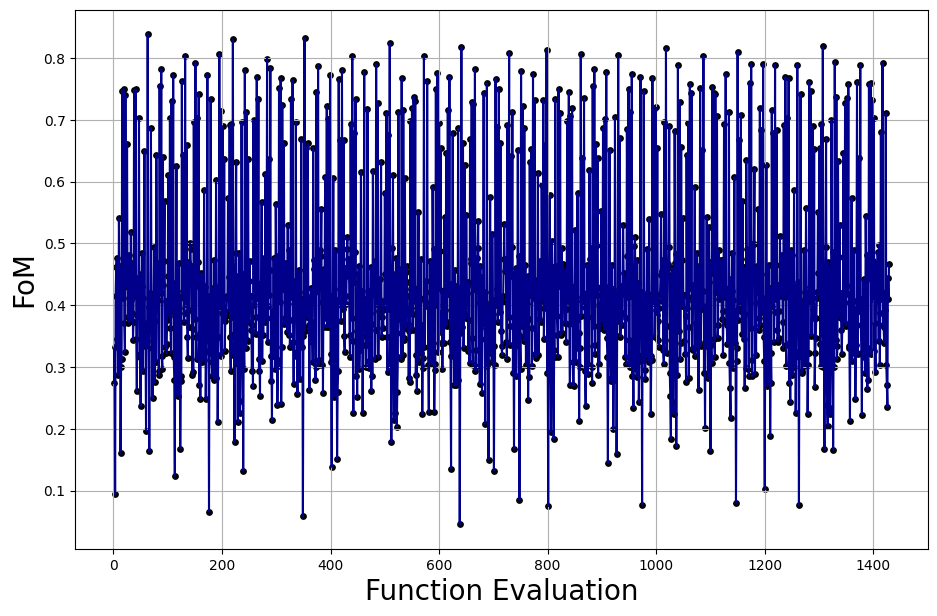

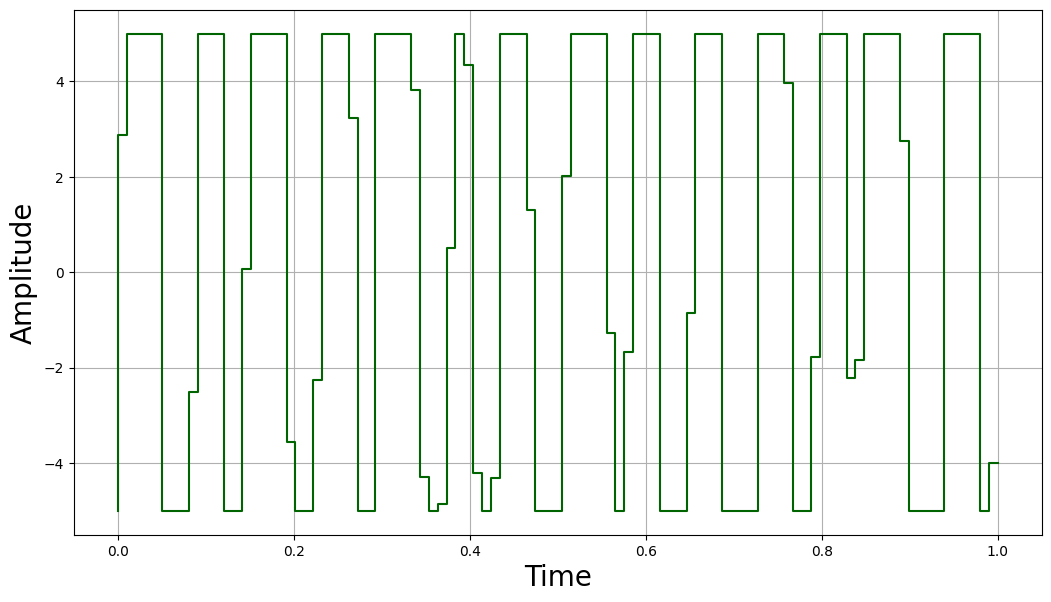

In [83]:

# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

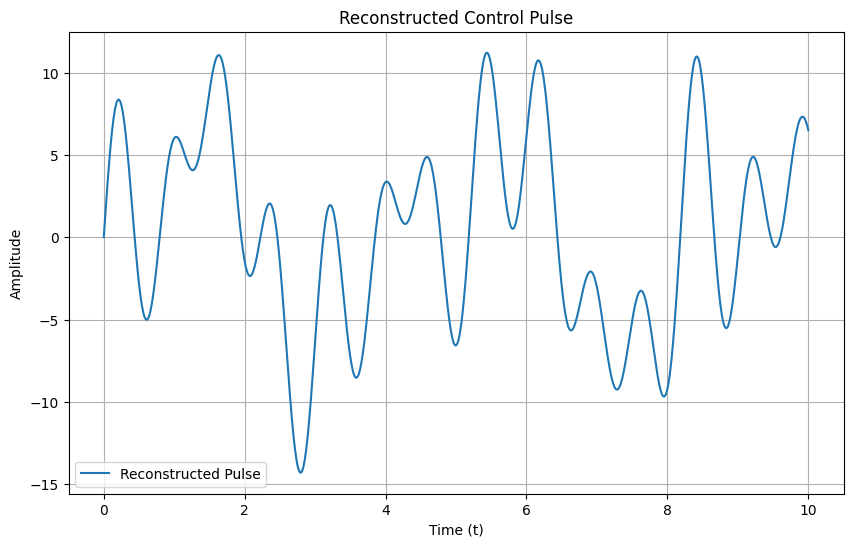

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_and_plot_pulse(dcrab_freq_list, dcrab_para_list, t_max, num_points):
    """
    Reconstructs and plots the control pulse using dCRAB frequencies and parameters.

    Parameters:
        dcrab_freq_list (list): Frequencies for each super-iteration.
        dcrab_para_list (list): Coefficients for each super-iteration.
        t_max (float): Maximum time for the pulse duration.
        num_points (int): Number of points to sample the pulse.
    """
    t = np.linspace(0, t_max, num_points)
    pulse = np.zeros_like(t)

    # Loop through all super-iterations
    for freq_iter, coeff_iter in zip(dcrab_freq_list, dcrab_para_list):
        for A, omega in zip(coeff_iter, freq_iter):
            pulse += A * np.sin(omega * t)

    # Plot the reconstructed pulse
    plt.figure(figsize=(10, 6))
    plt.plot(t, pulse, label='Reconstructed Pulse')
    plt.title('Reconstructed Control Pulse')
    plt.xlabel('Time (t)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()

# Example usage
dcrab_freq_list = [
    [1.456448461559252, 2.8302227472895654, 4.654052642944391, 6.182084238073395, 8.403989662825307],
    [0.5120880738527933, 2.285856802111401, 4.836916341324976, 7.486344860579068, 9.390295327110016],
    [0.84872089038921, 2.685154426645498, 4.55310061216272, 7.5899477725537565, 9.159695425203571]
]
dcrab_para_list = [
    [5.02219797, -3.43407842, 1.67328855, 2.85270903, 4.73810656],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0]
]

reconstruct_and_plot_pulse(dcrab_freq_list, dcrab_para_list, t_max=10.0, num_points=1000)